## ECG Arrhythmia Classification

In [1]:
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

from tensorflow.keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from tensorflow.keras.layers import Input, BatchNormalization, Activation
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### Load Dataset

ECG Dataset :  MIT-BIH Arrhythmia Dataset

    Number of Samples: 109446
    Number of Categories: 5
    Sampling Frequency: 125Hz
    Data Source: Physionet's MIT-BIH Arrhythmia Dataset
    Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]


-N : Non-ecotic beats (normal beat)
-S : Supraventricular ectopic beats
-V : Ventricular ectopic beats
-F : Fusion Beats
-Q : Unknown Beats


In [2]:
train_df=pd.read_csv('../data/ecg/mitbih_train.csv',header=None)
test_df=pd.read_csv('../data/ecg/mitbih_test.csv',header=None)

### Balancing the dataset

In [3]:
train_df[187]=train_df[187].astype(int)
equilibre=train_df[187].value_counts()
print(equilibre)

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


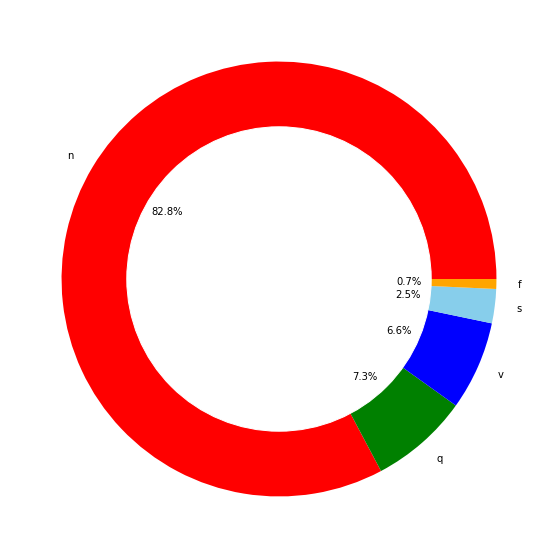

In [4]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [5]:
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

equilibre=train_df[187].value_counts()
print(equilibre)

4    20000
3    20000
2    20000
1    20000
0    20000
Name: 187, dtype: int64


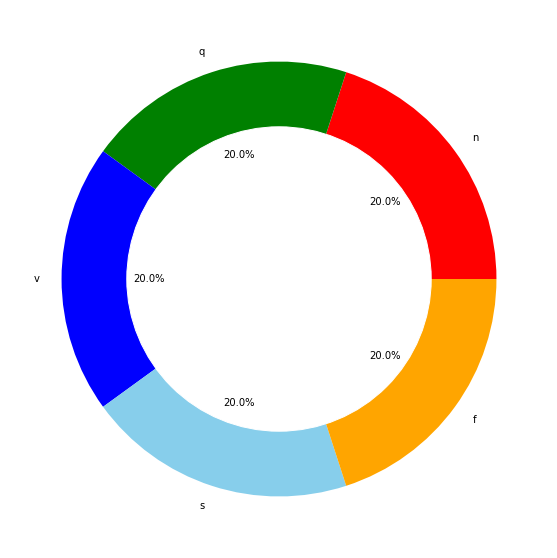

In [6]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

## Training a DNN

In [7]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
target_train=train_df[187]
target_test=test_df[187]

X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(100000, 186, 1)
(21892, 186, 1)
(100000, 5)
(21892, 5)


### Model Architecture

In [8]:
def network(X_train, p=0.3):

    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape, name='Conv1', padding='same')(inputs_cnn)
    conv1_1=BatchNormalization(name='Bn1')(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same", name='Mp1')(conv1_1)
    pool1 = Dropout(p, name='Drop1')(pool1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape,  name='Conv2', padding='same')(pool1)
    conv2_1=BatchNormalization( name='Bn2')(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same",  name='Mp2')(conv2_1)
    pool2 = Dropout(p, name='Drop2')(pool2)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape,  name='Conv3', padding='same')(pool2)
    conv3_1=BatchNormalization( name='Bn3')(conv3_1)
    conv3_1=MaxPool1D(pool_size=(2), strides=(2), padding="same",  name='Mp3')(conv3_1)
    conv3_1 = Dropout(p, name='Drop3')(conv3_1)
    flatten=Flatten( name='Flatten')(conv3_1)
    dense_end1 = Dense(64, activation='relu',  name='Dense1')(flatten)
    dense_end1 = Dropout(p, name='Drop4')(dense_end1)
    dense_end2 = Dense(32, activation='relu',  name='Dense2')(dense_end1)
    logits = Dense(5, name='logits')(dense_end2)
    probs = Activation('softmax', name='probs')(logits)
    
    model = Model(inputs= inputs_cnn, outputs=probs)
    print(model.summary())
    
    return model  

In [9]:
def train_CNN_model(model, X_train, y_train, X_val, y_val, model_dir,r, t, batch_size=256, epochs=50):
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # checkpoint
    chk_path = os.path.join(model_dir, f'best_{NAME}_{r}_{t}')
    checkpoint = ModelCheckpoint(chk_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]

    history = model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                shuffle=True,
                validation_data=(X_val, y_val),
                callbacks=callbacks_list)
    
    #Saving the model
    model.save(os.path.join(model_dir, 'final_{}_{}_{}'.format(NAME,r,t)))
    return model, history

In [10]:
model = network(X_train)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs_cnn (InputLayer)      [(None, 186, 1)]          0         
_________________________________________________________________
Conv1 (Conv1D)               (None, 186, 64)           448       
_________________________________________________________________
Bn1 (BatchNormalization)     (None, 186, 64)           256       
_________________________________________________________________
Mp1 (MaxPooling1D)           (None, 93, 64)            0         
_________________________________________________________________
Drop1 (Dropout)              (None, 93, 64)            0         
_________________________________________________________________
Conv2 (Conv1D)               (None, 93, 64)            12352     
_________

In [49]:
NAME = 'ECG_CNN'
t = 1
#t = int(time.time())

model, history = train_CNN_model(model, X_train, y_train, X_test, y_test, '.\Models', t, batch_size=256, epochs=100)

Train on 100000 samples, validate on 21892 samples
Epoch 1/100
 99840/100000 [============================>.] - ETA: 0s - loss: 0.5482 - acc: 0.7986
Epoch 00001: val_acc improved from -inf to 0.06738, saving model to .\Models\best_ECG_CNN_1
100000/100000 [==============================] - 7s 69us/sample - loss: 0.5479 - acc: 0.7987 - val_loss: 4.2712 - val_acc: 0.0674
Epoch 2/100
 98816/100000 [============================>.] - ETA: 0s - loss: 0.3032 - acc: 0.8887
Epoch 00002: val_acc improved from 0.06738 to 0.73442, saving model to .\Models\best_ECG_CNN_1
100000/100000 [==============================] - 5s 47us/sample - loss: 0.3029 - acc: 0.8889 - val_loss: 0.6276 - val_acc: 0.7344
Epoch 3/100
 99840/100000 [============================>.] - ETA: 0s - loss: 0.2332 - acc: 0.9142
Epoch 00003: val_acc improved from 0.73442 to 0.83885, saving model to .\Models\best_ECG_CNN_1
100000/100000 [==============================] - 5s 47us/sample - loss: 0.2331 - acc: 0.9142 - val_loss: 0.4277 -

 99584/100000 [============================>.] - ETA: 0s - loss: 0.0749 - acc: 0.9732
Epoch 00028: val_acc did not improve from 0.96793
100000/100000 [==============================] - 5s 49us/sample - loss: 0.0749 - acc: 0.9731 - val_loss: 0.1210 - val_acc: 0.9616
Epoch 29/100
 98816/100000 [============================>.] - ETA: 0s - loss: 0.0737 - acc: 0.9736
Epoch 00029: val_acc did not improve from 0.96793
100000/100000 [==============================] - 5s 49us/sample - loss: 0.0736 - acc: 0.9736 - val_loss: 0.1084 - val_acc: 0.9672
Epoch 30/100
 98816/100000 [============================>.] - ETA: 0s - loss: 0.0710 - acc: 0.9751
Epoch 00030: val_acc did not improve from 0.96793
100000/100000 [==============================] - 5s 49us/sample - loss: 0.0709 - acc: 0.9752 - val_loss: 0.1272 - val_acc: 0.9599
Epoch 31/100
 98816/100000 [============================>.] - ETA: 0s - loss: 0.0702 - acc: 0.9753
Epoch 00031: val_acc did not improve from 0.96793
100000/100000 [============

Epoch 57/100
 98816/100000 [============================>.] - ETA: 0s - loss: 0.0562 - acc: 0.9802
Epoch 00057: val_acc did not improve from 0.97268
100000/100000 [==============================] - 5s 50us/sample - loss: 0.0562 - acc: 0.9802 - val_loss: 0.1042 - val_acc: 0.9683
Epoch 58/100
 98816/100000 [============================>.] - ETA: 0s - loss: 0.0566 - acc: 0.9798
Epoch 00058: val_acc did not improve from 0.97268
100000/100000 [==============================] - 5s 50us/sample - loss: 0.0565 - acc: 0.9798 - val_loss: 0.1131 - val_acc: 0.9676
Epoch 59/100
 98816/100000 [============================>.] - ETA: 0s - loss: 0.0542 - acc: 0.9809
Epoch 00059: val_acc did not improve from 0.97268
100000/100000 [==============================] - 5s 50us/sample - loss: 0.0541 - acc: 0.9809 - val_loss: 0.1232 - val_acc: 0.9628
Epoch 60/100
 98816/100000 [============================>.] - ETA: 0s - loss: 0.0556 - acc: 0.9804
Epoch 00060: val_acc did not improve from 0.97268
100000/100000 

Epoch 86/100
 99584/100000 [============================>.] - ETA: 0s - loss: 0.0469 - acc: 0.9833
Epoch 00086: val_acc did not improve from 0.97798
100000/100000 [==============================] - 5s 50us/sample - loss: 0.0469 - acc: 0.9833 - val_loss: 0.1115 - val_acc: 0.9679
Epoch 87/100
 99584/100000 [============================>.] - ETA: 0s - loss: 0.0468 - acc: 0.9839- ETA: 0s - loss: 0.0468 - acc: 0.98
Epoch 00087: val_acc did not improve from 0.97798
100000/100000 [==============================] - 5s 50us/sample - loss: 0.0469 - acc: 0.9838 - val_loss: 0.1356 - val_acc: 0.9630
Epoch 88/100
 99584/100000 [============================>.] - ETA: 0s - loss: 0.0486 - acc: 0.9832
Epoch 00088: val_acc did not improve from 0.97798
100000/100000 [==============================] - 5s 50us/sample - loss: 0.0488 - acc: 0.9832 - val_loss: 0.1397 - val_acc: 0.9550
Epoch 89/100
 98816/100000 [============================>.] - ETA: 0s - loss: 0.0478 - acc: 0.9834- ETA: 0s - loss: 0.0478 - ac

In [11]:
model = load_model(f'Models/best_ECG_CNN_1')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Evaluate Model

In [13]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = target_test
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
class_wise_f1 = f1_score(y_true, y_pred, average=None)
print('the mean-f1 score: {:.4f}'.format(np.mean(class_wise_f1)))
accuracy = accuracy_score(y_true, y_pred)
print('accuracy is: {:.4f}'.format(accuracy))

[[17747   215    42    98    16]
 [   56   487     8     3     2]
 [   21     7  1389    28     3]
 [    4     2     8   148     0]
 [    6     1     6     0  1595]]
the mean-f1 score: 0.8753
accuracy is: 0.9760
